In [1]:
# Setup notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}


In [2]:
store_sales = pd.read_csv(
    'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

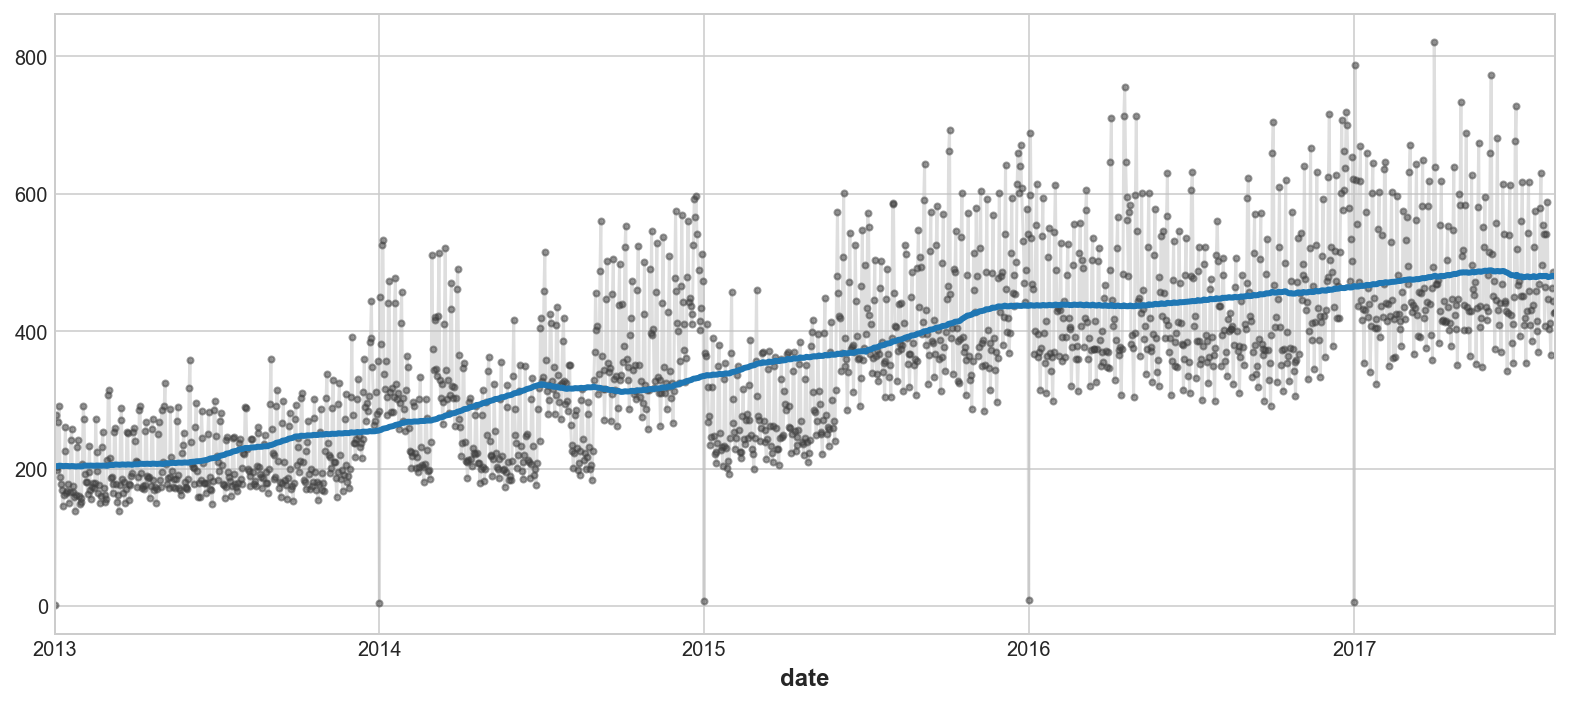

In [3]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

In [14]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()  # the target

dp = DeterministicProcess(index=y.index, order=8)
X = dp.in_sample()
X_fore = dp.out_of_sample(steps=90)

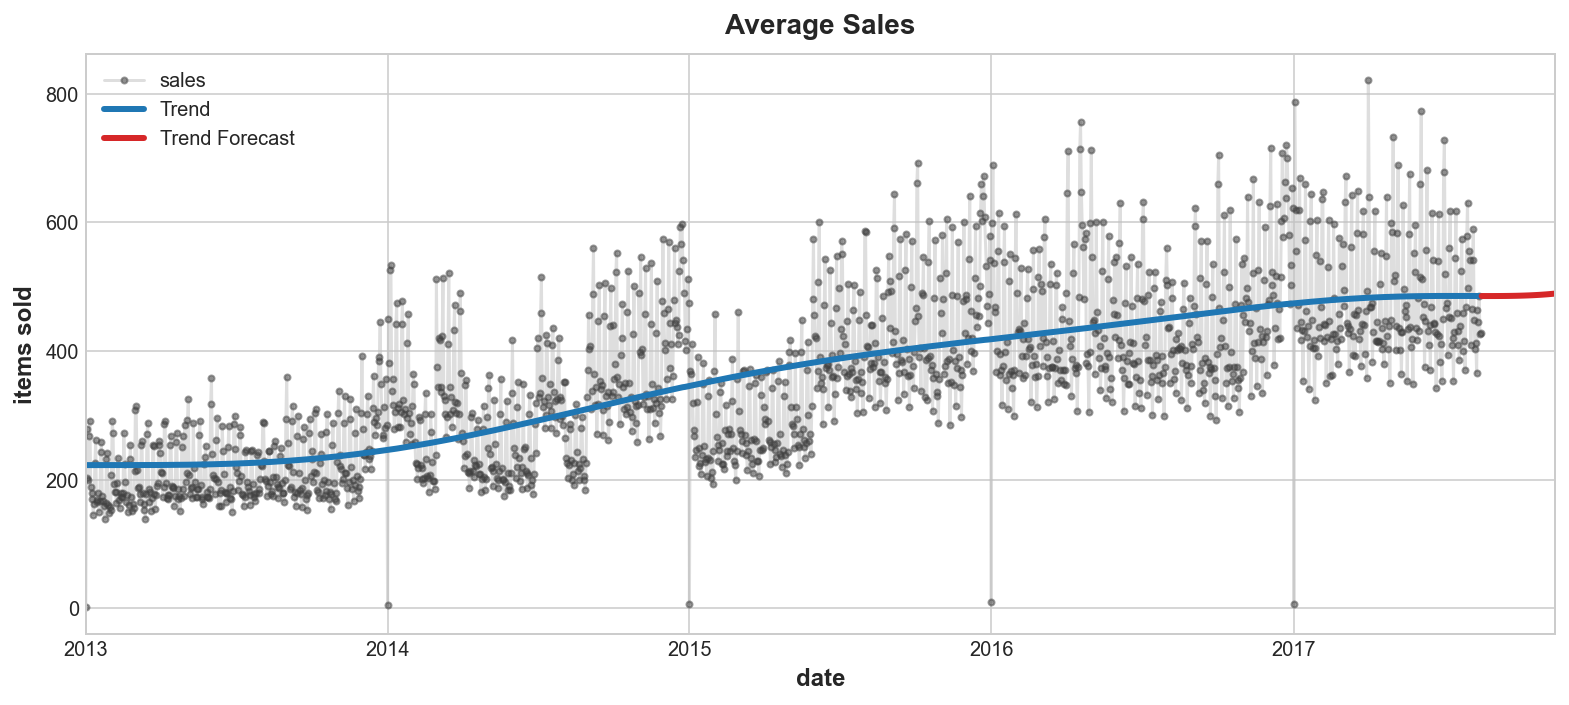

In [15]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

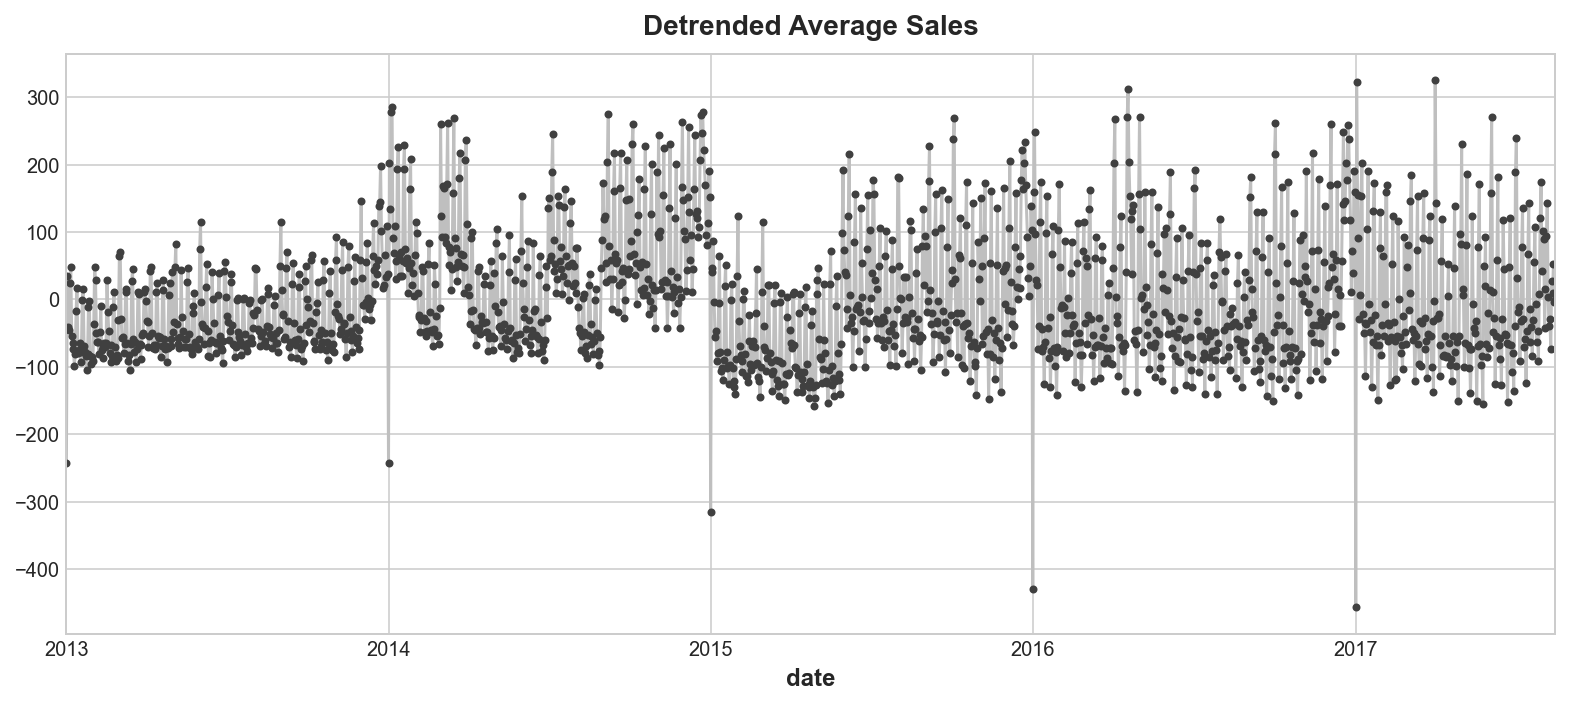

In [6]:
y_detrended = y - y_pred   # remove the trend from store_sales

y_detrended.plot(**plot_params, title="Detrended Average Sales");